# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import edhec_risk_kit as erk

In [2]:
# load industry returns and total market index
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [3]:
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
# fake safe asset
safe_r = pd.DataFrame().reindex_like(risky_r)

In [4]:
# enter fake safe value
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

In [5]:
risky_r.shape

(228, 3)

In [6]:
safe_r.shape

(228, 3)

In [7]:
# timing for loops
def compound1(r):
    return (1+r).prod()-1


def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [8]:
%timeit compound1(risky_r)

1.43 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit compound2(risky_r)

449 µs ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## CPPI Algorithm (for every unit of time)
1. Cushion -> asset value - floor value
2. Compute an allocation to safe and risky assets -> m*risk budget
3. Recompute asset value based on returns

In [10]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # update account value for timestamp
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save to look at history
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w

In [11]:
risky_wealth = start*(1+risky_r).cumprod()

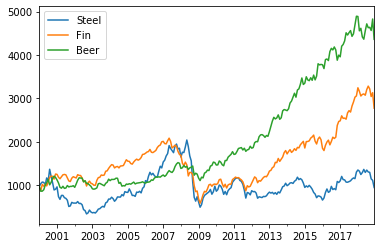

In [12]:
risky_wealth.plot()

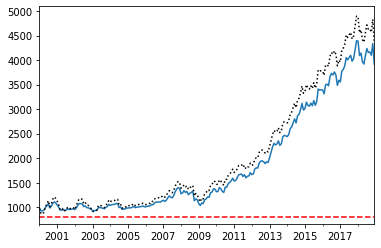

In [13]:
ind = ['Beer', 'Fin', 'Steel']

ax = account_history[ind[0]].plot()
risky_wealth[ind[0]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

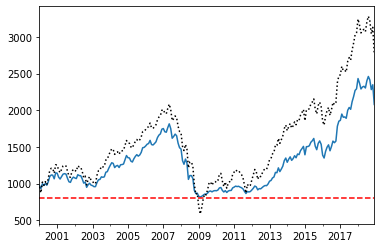

In [14]:
ax = account_history[ind[1]].plot()
risky_wealth[ind[1]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

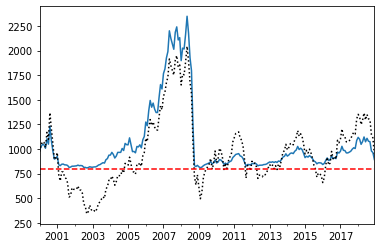

In [15]:
ax = account_history[ind[2]].plot()
risky_wealth[ind[2]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

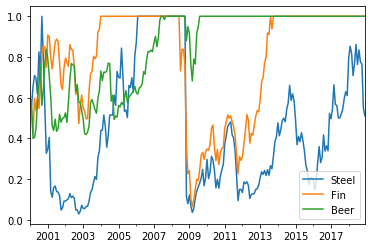

In [17]:
risky_w_history.plot()

In [19]:
# test new functions
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [23]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


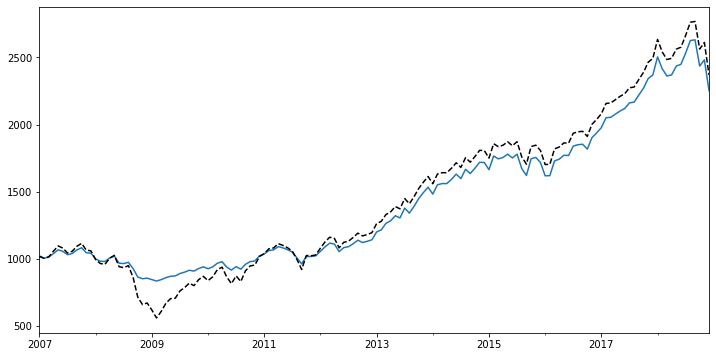

In [27]:
# for total market index from right before crash
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12, 6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)

In [28]:
# compare drawdowns of using strategy vs. not using strategy
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


In [29]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


## Drawdown Constraint

In [30]:
btr = erk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown = 0.25)

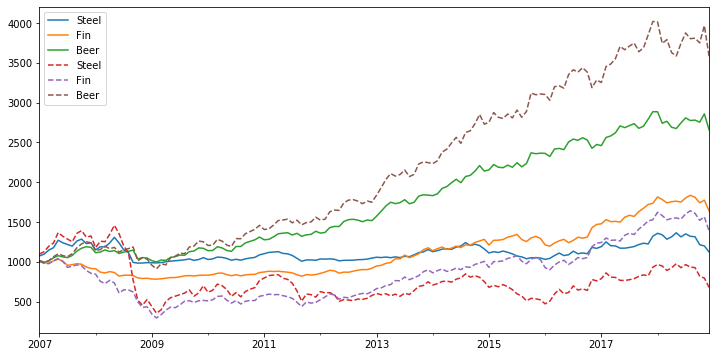

In [32]:
ax = btr['Wealth'].plot(figsize=(12, 6))
btr['Risky Wealth'].plot(ax=ax, style='--')

In [33]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [35]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
